In [1]:
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

import itertools
import os

%matplotlib inline
sns.set(style="whitegrid")


trainpath = '../input/intel-image-classification/seg_train/'
testpath = '../input/intel-image-classification/seg_test/'
predpath = '../input/intel-image-classification/seg_pred/'

# Open Folders

### now let's first check the Train folder to have a look to its content

In [2]:
for folder in  os.listdir(trainpath + 'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 2512 in folder mountain
For training data , found 2382 in folder street
For training data , found 2191 in folder buildings
For training data , found 2274 in folder sea
For training data , found 2271 in folder forest
For training data , found 2404 in folder glacier


### ok , how about the test folder

In [3]:
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str( testpath +'seg_test//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 525 in folder mountain
For testing data , found 501 in folder street
For testing data , found 437 in folder buildings
For testing data , found 510 in folder sea
For testing data , found 474 in folder forest
For testing data , found 553 in folder glacier


### now for prediction folder

In [4]:
files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
print(f'For Prediction data , found {len(files)}')

For Prediction data , found 7301


# Checking Images
### now we need to heck the images sizes , to know how they looks like

In [5]:
# now how about the images sizes in train folder

size = []
for folder in  os.listdir(trainpath +'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()


(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(143, 150, 3)        2
(108, 150, 3)        2
(146, 150, 3)        2
(142, 150, 3)        2
(123, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(144, 150, 3)        2
(81, 150, 3)         1
(149, 150, 3)        1
(119, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(97, 150, 3)         1
(105, 150, 3)        1
(141, 150, 3)        1
(110, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(145, 150, 3)        1
(140, 150, 3)        1
(124, 150, 3)        1
(103, 150, 3)        1
(100, 150, 3)        1
(131, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
dtype: int64

### ok , almost all of them are 150,150,3 , how about test images and prediction images ?

In [6]:
size = []
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str( testpath +'seg_test//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(72, 150, 3)        1
dtype: int64

In [7]:
# prediction images
size = []
files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
for file in files: 
    image = cv2.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    7288
(139, 150, 3)       1
(108, 150, 3)       1
(129, 150, 3)       1
(143, 150, 3)       1
(149, 150, 3)       1
(144, 150, 3)       1
(133, 150, 3)       1
(112, 150, 3)       1
(100, 150, 3)       1
(374, 500, 3)       1
(126, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
dtype: int64

### ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

# Reading Images
### now it's time to read all images & convert it into arrays


#### lets make a function to label the images

In [8]:
# since we have 6 categories , we first need to create a dictionary with their names & indices

code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(label) :
    """
    function to get the image code back by comparison with the sent label
    
    Parameters
    ----------
    label : the number sent to get the image name
    
    Returns
    -------
    img_name : name of the image with the assigned code
    """
    for img_name , img_code in code.items() : 
        if label == img_code : 
            return img_name 

#### function to read the images

In [9]:

def images_read(file_path:str, folder_name:str, img_size:int, labeled:bool):
    """
    read the images after resize it and assign the label value
    
    Parameters
    ----------
    file_path : str
            the path of the file to get images from
    
    folder_name : str
            the folder name that contain the images or folders of images
    
    img_size : int
            size used to resize the image
    
    labeled : bool
            if True the images will be labeled
            if False will return only the X_matrix
            
    """
    X_mat = []
    y_mat = []
    
    if labeled:
        for folder in  os.listdir(file_path +folder_name) : 
            files = gb.glob(pathname= str( file_path + folder_name +'//' + folder + '/*.jpg'))
            for file in files: 
                image = cv2.imread(file)
                image_array = cv2.resize(image , (img_size,img_size))
                image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
                X_mat.append(list(image_array))
                y_mat.append(code[folder]) #code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
        return X_mat, y_mat
    else:
        files = gb.glob(pathname= str(file_path + folder_name + '/*.jpg'))
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (img_size,img_size))
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
            X_mat.append(list(image_array))       
        return X_mat

#### and function to display the images

In [10]:
def images_display(data, title=None):
    """
    Display number of random images 
    
    Parameters
    ----------
    data : array-like or PIL image
           the images to be display
           
    title : the images labels to be set as a title
    
    Returns : image
    """
    if title == None:
        plt.figure(figsize=(20,20))
        for n , i in enumerate(list(np.random.randint(0,len(data),36))) : 
            plt.subplot(6,6,n+1)
            plt.imshow(data[i], cmap="gray")    
            plt.axis('off')
    else:
        plt.figure(figsize=(20,20))
        for n , i in enumerate(list(np.random.randint(0,len(data),36))) : 
            plt.subplot(6,6,n+1)
            plt.imshow(data[i], cmap="gray")    
            plt.axis('off')
            plt.title(getcode(title[i]))

## we need the matrix to be in the shape of (:, :, :, :) so we be able to enter it into tensorflow 
### the first dim is: the number of images
### the second and third dim is: the shape of the images
### the last dim is: the number of channels

In [11]:
def add_dim(arr):
    """
    adding the number 1 in the last dimension 
    """
    return arr[:, :, :, np.newaxis]

In [12]:
# first we'll create a variable s , which refer to size , so we can change it easily

# let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

s = 100

X_train, y_train = images_read(file_path=trainpath, folder_name="seg_train", img_size=s, labeled=True)
print(f'we have {len(X_train)} items in X_train')

we have 14034 items in X_train


### let's take a look at random pictures in X_train, and adjust their title using the y value

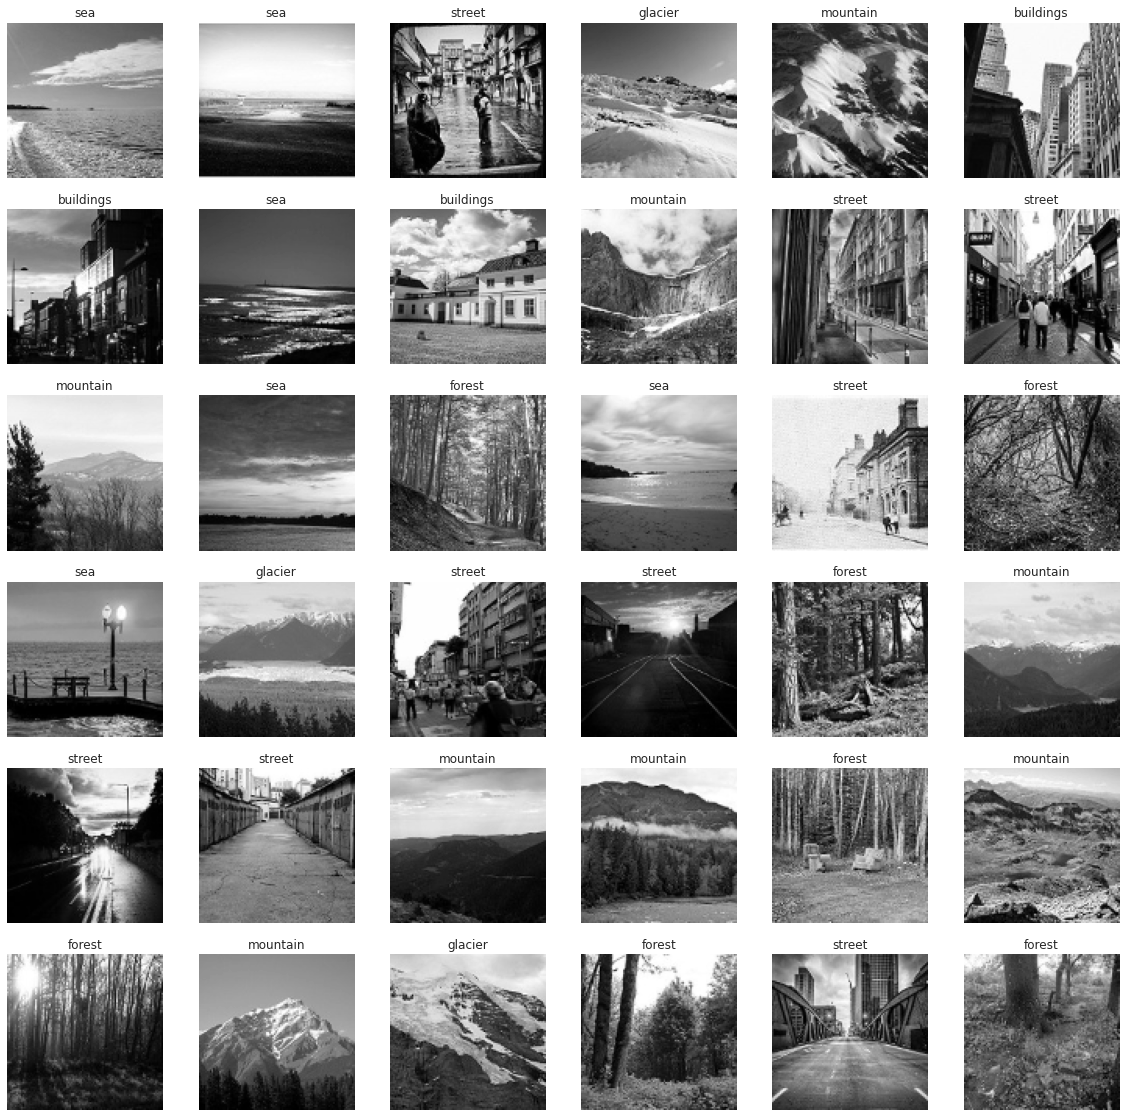

In [13]:
images_display(X_train, title=y_train)

In [14]:
# now read the test data and display some
X_test, y_test = images_read(file_path=testpath, folder_name="seg_test", img_size=s, labeled=True)
print(f'we have {len(X_test)} items in X_test')

we have 3000 items in X_test


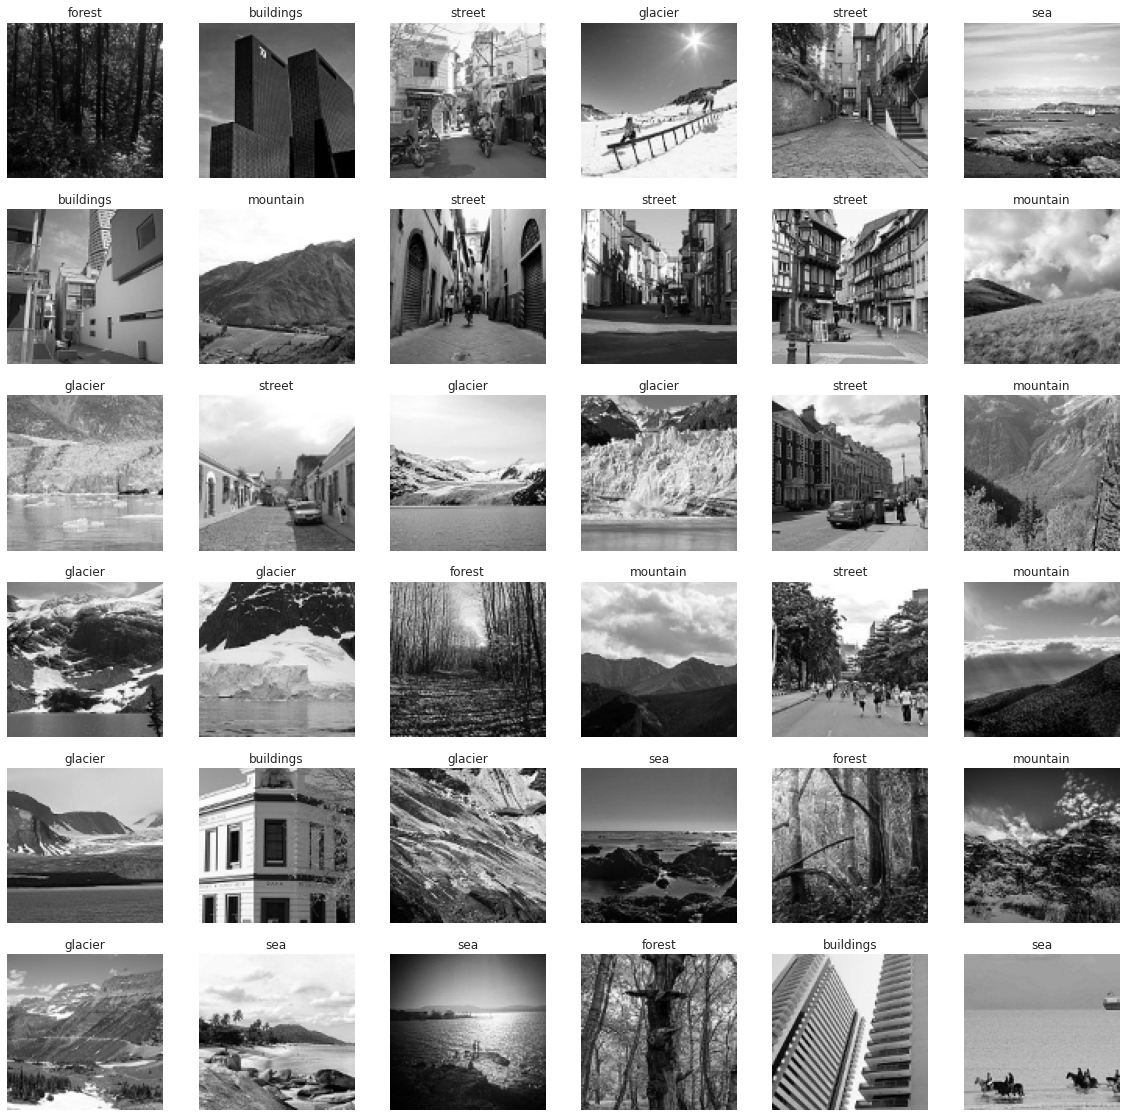

In [15]:
images_display(data=X_test, title=y_test)

In [16]:
# also with Prediction data , without having labeles ofcourse

X_pred = images_read(file_path=predpath, folder_name="seg_pred", img_size=s, labeled=False)  
print(f'we have {len(X_pred)} items in X_pred')

we have 7301 items in X_pred


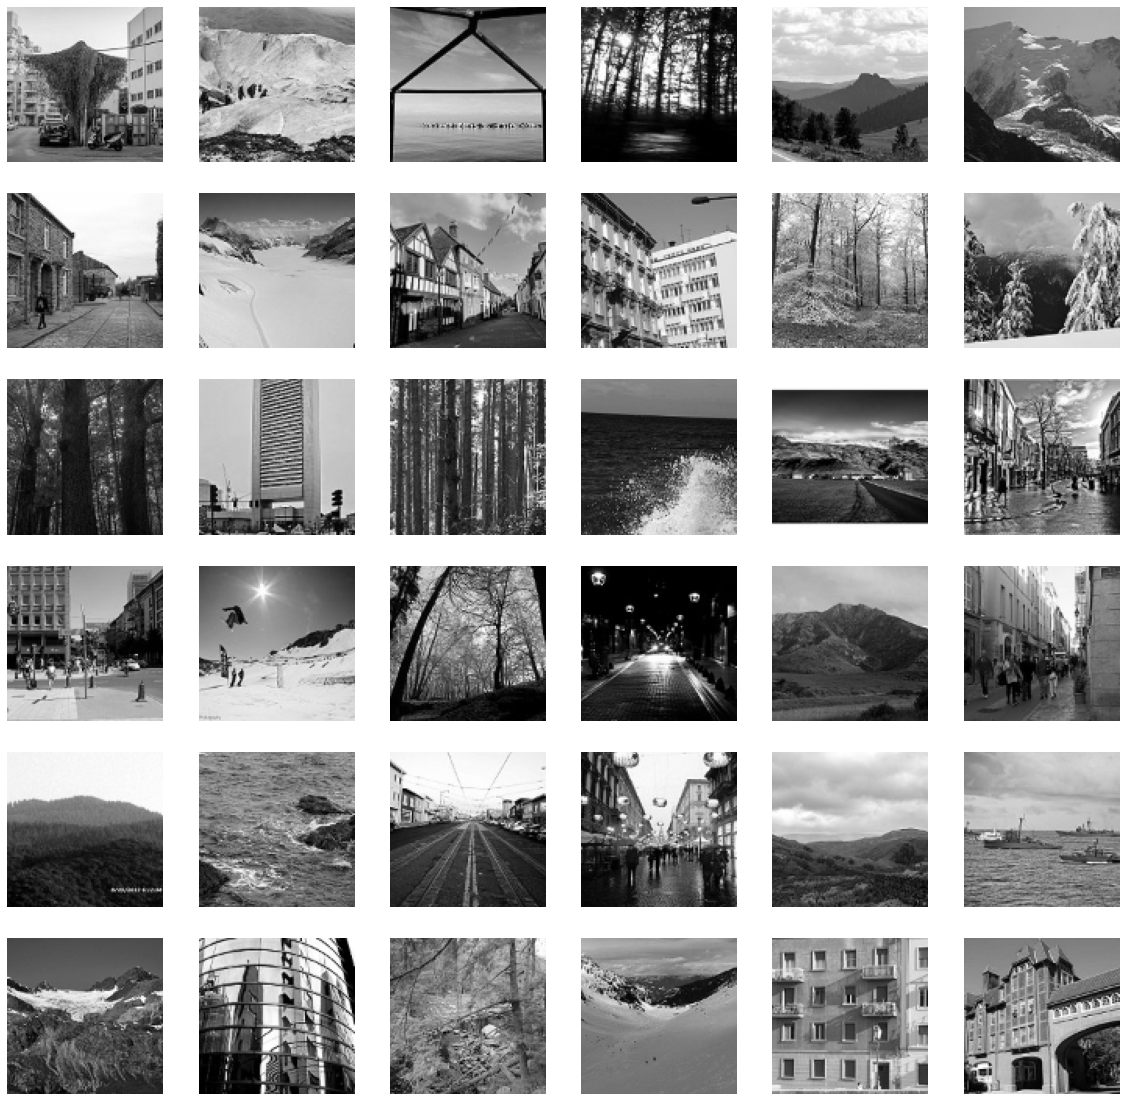

In [17]:
images_display(data=X_pred)

# Building The Model
### now we need to build the model to train our data


In [18]:
# first to convert the data into arrays using numpy

X_train = add_dim(np.array(X_train))
X_test = add_dim(np.array(X_test))
X_pred_array = add_dim(np.array(X_pred))

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'X_pred shape  is {X_pred_array.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (14034, 100, 100, 1)
X_test shape  is (3000, 100, 100, 1)
X_pred shape  is (7301, 100, 100, 1)
y_train shape  is (14034,)
y_test shape  is (3000,)


### now to build the CNN model by Keras , using Conv2D layers , MaxPooling & Denses

In [19]:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(240,kernel_size=(3,3),activation='relu',input_shape=(s,s,1)),
        keras.layers.Conv2D(144,kernel_size=(3,3),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Dropout(rate=0.3),
    
        keras.layers.Conv2D(104,kernel_size=(3,3),activation='relu'),
        keras.layers.Conv2D(96,kernel_size=(3,3),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Dropout(rate=0.3),
    
        keras.layers.Flatten(),
        keras.layers.Dense(120,activation='relu') ,
        keras.layers.Dense(80,activation='relu') ,
        keras.layers.Dropout(rate=0.3),
        keras.layers.Dense(6,activation='softmax') ,
        ])

2022-05-16 13:00:24.565834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 13:00:24.710185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 13:00:24.711377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 13:00:24.713891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### now to compile the model , using adam optimizer , & sparse categorical crossentropy loss

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
KerasModel.compile(optimizer =opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### let's get some description on the model architecture

In [21]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 240)       2400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 144)       311184    
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 144)       576       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 144)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 144)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 104)       134888    
_________________________________________________________________
conv2d_3 (Conv2D)            (None,

#### Reduce learning rate when a metric has stopped improving.

#### Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [22]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#### Stop training when a monitored metric has stopped improving.

#### This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

In [23]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=4)

# Train the model

#### lets use 10 epochs for now

In [24]:
# now to train the model

epochs = 10
KerasModel.fit(X_train, y_train, 
                           epochs=epochs,
                           validation_data=(X_test,y_test),
                           batch_size=64,verbose=1,
                           callbacks=[learning_rate_reduction, callback]
                          )


2022-05-16 13:00:30.274559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-16 13:00:31.733827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


220/220 [==============================] - 36s 124ms/step - loss: 1.9030 - accuracy: 0.3368 - val_loss: 2.7730 - val_accuracy: 0.2407
Epoch 2/10
220/220 [==============================] - 26s 119ms/step - loss: 1.2841 - accuracy: 0.4522 - val_loss: 1.2039 - val_accuracy: 0.5017
Epoch 3/10
220/220 [==============================] - 26s 119ms/step - loss: 1.1657 - accuracy: 0.5230 - val_loss: 1.4729 - val_accuracy: 0.3990
Epoch 4/10
220/220 [==============================] - 26s 119ms/step - loss: 1.0292 - accuracy: 0.6015 - val_loss: 2.1635 - val_accuracy: 0.4563
Epoch 5/10
220/220 [==============================] - 26s 119ms/step - loss: 0.9233 - accuracy: 0.6519 - val_loss: 2.9000 - val_accuracy: 0.3113
Epoch 6/10
220/220 [==============================] - 26s 119ms/step - loss: 0.8433 - accuracy: 0.6962 - val_loss: 0.9499 - val_accuracy: 0.6467
Epoch 7/10
220/220 [==============================] - 26s 119ms/step - loss: 0.7714 - accuracy: 0.7253 - val_loss: 0.8489 - val_accuracy: 0.7

In [25]:
from keras.models import model_from_json

# serialize model to JSON
model_json = KerasModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
KerasModel.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
# now to predict X test

y_pred = loaded_model.predict(X_test)

print('Prediction Shape is {}'.format(y_pred.shape))

Prediction Shape is (3000, 6)


# Confusion matrix 

### now it's time to predict X Predict

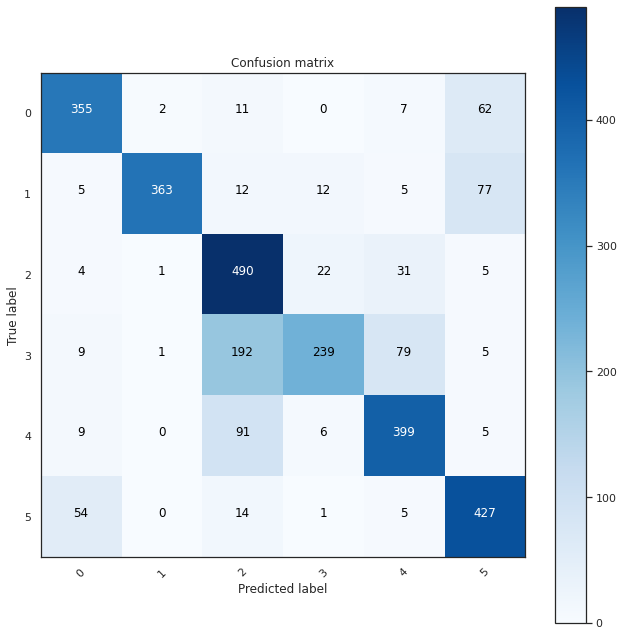

In [28]:
# Look at confusion matrix 

sns.set(style='white', context='notebook', palette='deep')
plt.figure(figsize=(9,9))

def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Parameters
    ------------    
    cm : confusion_matrix
    
    classes : int 
        the number of labels
    
    title : str default: 'Confusion matrix'
        title to be set for the chart
    
    cmap : str or Colormap, (default: 'Blues')
        A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
        
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = loaded_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# get validation labels
Y_true = y_test
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6)) 

In [29]:
y_result = loaded_model.predict(X_pred_array)

print('Prediction Shape is {}'.format(y_result.shape))

Prediction Shape is (7301, 6)


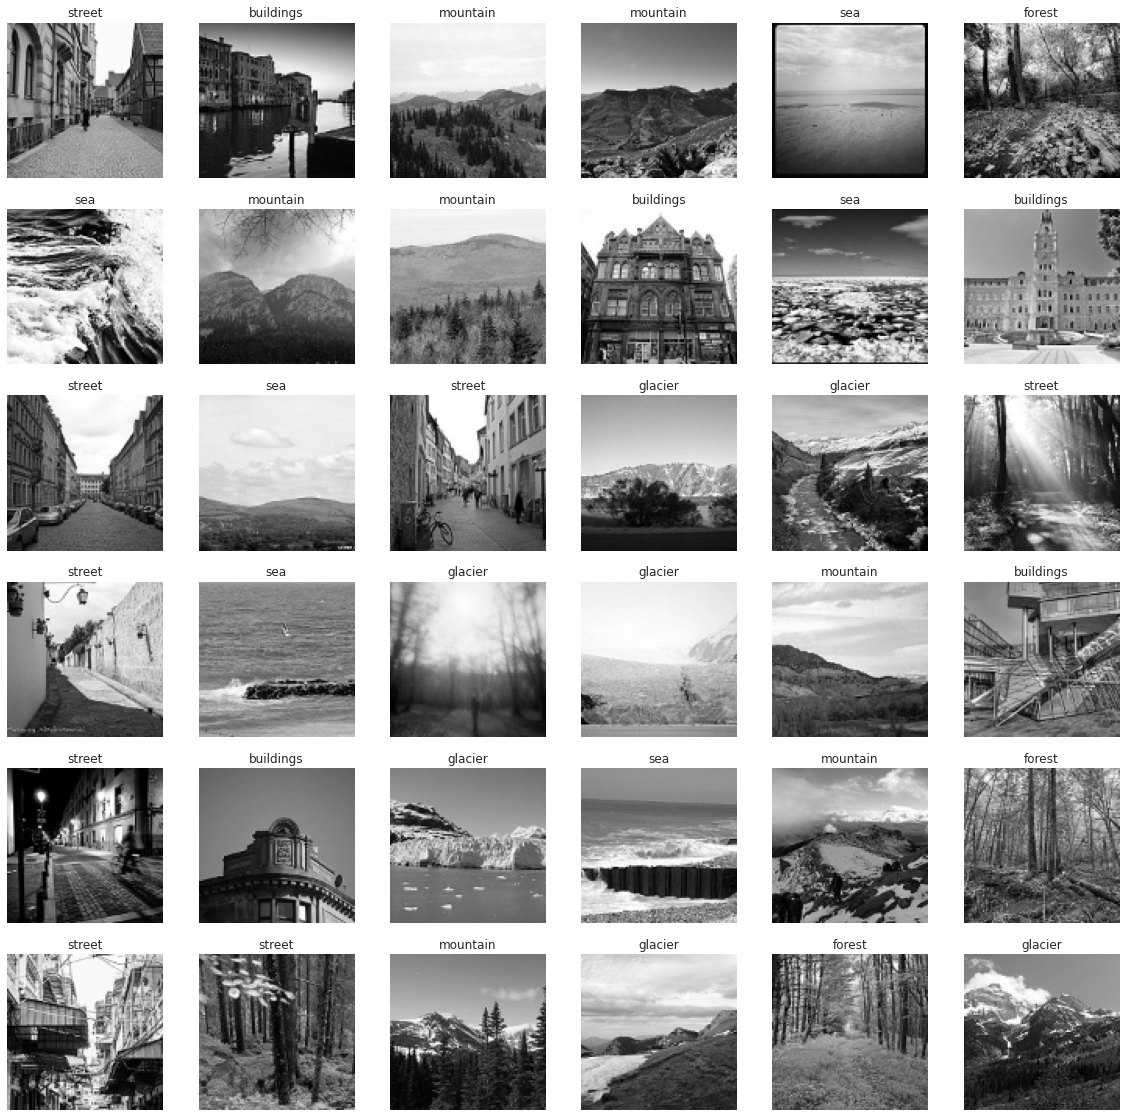

In [30]:
# and to show random redicted pictures & its predicting category

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i], cmap="gray")    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))